In [3]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("./housing.csv")
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Since This is a object type data, probably string, we need to find how many types of them there are
dataset["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

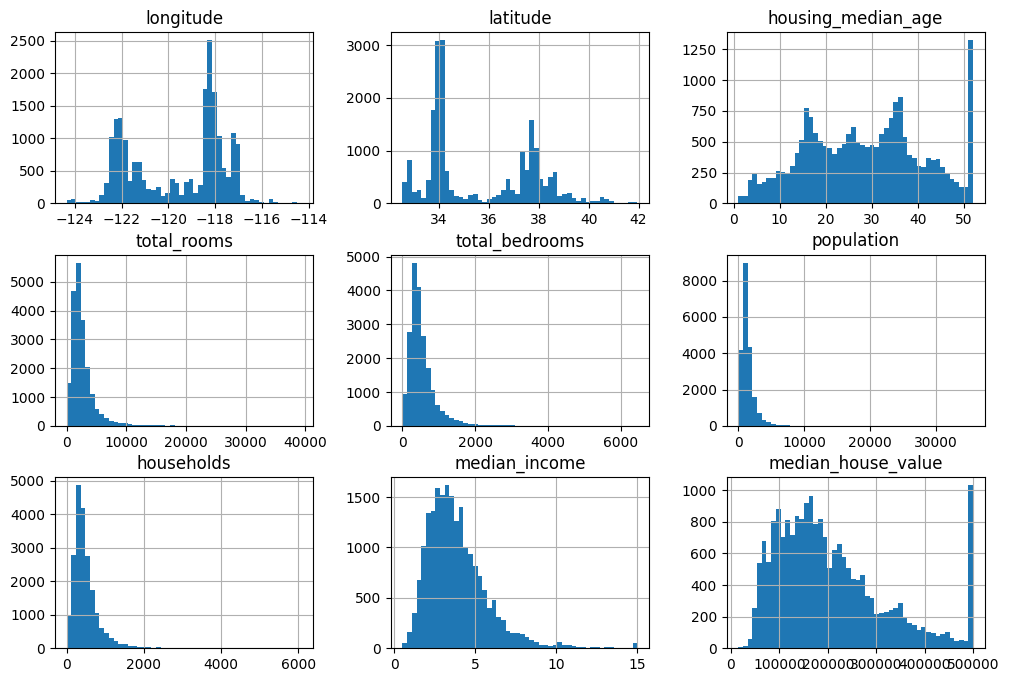

In [6]:
import matplotlib.pyplot as plt
dataset.hist(bins = 50, figsize = (12, 8))
plt.show()
# We can see from the histogram that a lot of the data is right-skewed. We can also see that the median_income and median_house_value data have been capped.

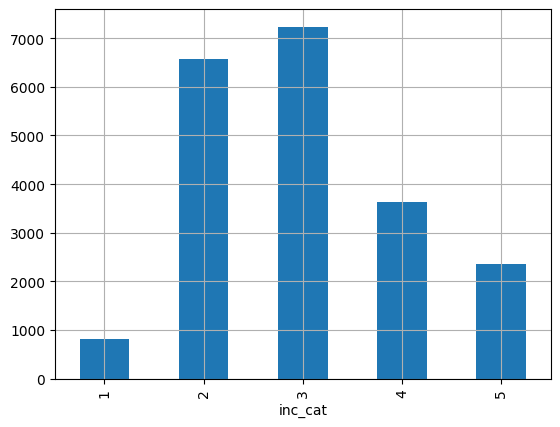

In [7]:
#Assuming median_income is going to be very important in predicting the house_value, we can stratify it to get a better training and testing sets.
dataset["inc_cat"] = pd.cut(dataset["median_income"], bins = [0., 1.5, 3, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])
dataset["inc_cat"].value_counts().sort_index().plot.bar(grid = True)
plt.show()

In [8]:
#Generating the training and testing set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size = 0.2, stratify=dataset["inc_cat"], random_state = 1)
train_set.head()                     

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,inc_cat
19466,-120.97,37.68,16.0,2349.0,446.0,1302.0,392.0,3.1625,130300.0,INLAND,3
18145,-122.04,37.34,28.0,3081.0,460.0,1260.0,461.0,7.5372,432600.0,<1H OCEAN,5
15241,-117.23,32.99,17.0,2718.0,326.0,1011.0,319.0,15.0001,500001.0,NEAR OCEAN,5
4006,-118.63,34.16,33.0,2896.0,455.0,1116.0,411.0,6.0192,347700.0,<1H OCEAN,5
2679,-115.53,32.99,25.0,2578.0,634.0,2082.0,565.0,1.7159,62200.0,INLAND,2


In [9]:
#Since we aren't going to be using inc_cat is not a feature we can drop it from out training and testing sets
for df in (train_set, test_set):
    df.drop("inc_cat", axis = 1, inplace = True)


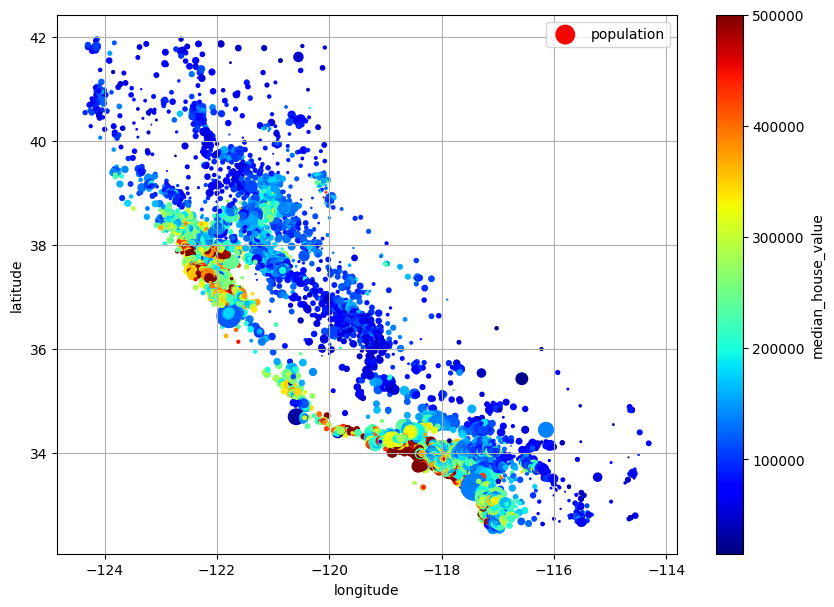

In [10]:
dataset.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, s = dataset["population"] / 100, label = "population", c = "median_house_value", cmap = "jet", colorbar = True, legend = True, sharex=False, figsize= (10, 7))
plt. show()

In [11]:
housing = train_set.drop("median_house_value", axis = 1)
housing_labels = train_set["median_house_value"].copy()

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1.0,  random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight = sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    
    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [13]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
def column_ratio(x):
    return x[:, [0]] / x[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return["ratio"]

def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(column_ratio, feature_names_out=ratio_name), StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(np.log, feature_names_out = "one-to-one"), StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1., random_state = 1)
default_num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown = "ignore"))

preprocessing = ColumnTransformer([("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]), ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]), 
                                   ("people_per_house", ratio_pipeline(), ["population", "households"]), 
                                   ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]), 
                                   ("geo", cluster_simil, ["latitude", "longitude"]), ("cat", cat_pipeline, make_column_selector(dtype_include=object)), ], 
                                   remainder = default_num_pipeline)

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape
preprocessing.get_feature_names_out()

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=1),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f229d9b0410>)])),
                ('linearregression', LinearRegression())])

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state = 1))
tree_reg.fit(housing, housing_labels)

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2...
                                                  ClusterSimilarity(random_state=1),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f229d9b0410>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1))])

In [19]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
tree_rmse

0.0

In [20]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring = "neg_root_mean_squared_error", cv = 10)
pd.Series(tree_rmses).describe()

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

count       10.000000
mean     66543.220542
std       1259.447578
min      64715.180517
25%      65663.704989
50%      66755.211671
75%      67492.397901
max      68076.459836
dtype: float64

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state = 1))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv = 10)
pd.Series(forest_rmses).describe()

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

count       10.000000
mean     47193.697925
std       1553.984536
min      44735.157106
25%      46288.336764
50%      47377.532739
75%      48096.218962
max      49786.967315
dtype: float64

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state = 1)),
])

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50), 'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state = 1)

rnd_search.fit(housing, housing_labels)

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=1))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f229fe37210>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f229fe37bd0>},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [31]:
final_model = rnd_search.best_estimator_
feature_importance = final_model["random_forest"].feature_importances_
feature_importance.round(2)

array([0.06, 0.05, 0.06, 0.01, 0.01, 0.01, 0.01, 0.25, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.02, 0.02, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.02, 0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.02, 0.  , 0.01, 0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.01])

In [33]:
sorted(zip(feature_importance, final_model["preprocessing"].get_feature_names_out()), reverse = True)

[(0.252670822153492, 'log__median_income'),
 (0.10020844164866856, 'cat__ocean_proximity_INLAND'),
 (0.06487413831773976, 'people_per_house__ratio'),
 (0.06399896933400367, 'bedrooms__ratio'),
 (0.05151588162212433, 'rooms_per_house__ratio'),
 (0.03191504986110464, 'geo__Cluster 33 similarity'),
 (0.02307411458191091, 'geo__Cluster 10 similarity'),
 (0.022976845548302236, 'geo__Cluster 36 similarity'),
 (0.01997453469437774, 'geo__Cluster 11 similarity'),
 (0.019539473978949885, 'geo__Cluster 27 similarity'),
 (0.017529032547348087, 'geo__Cluster 26 similarity'),
 (0.017040745267493555, 'geo__Cluster 2 similarity'),
 (0.0162854451293498, 'geo__Cluster 19 similarity'),
 (0.014839905212808212, 'remainder__housing_median_age'),
 (0.014511897358106013, 'geo__Cluster 15 similarity'),
 (0.01230024168743624, 'geo__Cluster 22 similarity'),
 (0.012166562666298179, 'geo__Cluster 30 similarity'),
 (0.01117779180945177, 'geo__Cluster 34 similarity'),
 (0.010170275560877665, 'geo__Cluster 21 simila

In [34]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

40758.54629262047


In [72]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_regressor = Pipeline([
    ("preprocessing", preprocessing),
    ("svr", SVR(kernel = "rbf")),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [240],
     'svr__C': [20000],
     'svr__gamma' : [0.05, 0.025, 0.075]},
]
grid_search = GridSearchCV(svr_regressor, param_grid, cv = 3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing[:5000], housing_labels[:5000])

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f229d9b0410>)])),
                                       ('svr', SVR())]),
             param_grid=[{'preprocessing__geo__n_clusters': [240],
                          'svr__C': [20000],
                          'svr__gamma': [0.05, 0.025, 0.075]}],
             scoring='neg_root_mean_squared_error')

In [73]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 240, 'svr__C': 20000, 'svr__gamma': 0.05}

In [74]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_svr__C", "param_svr__gamma", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "C", "gamma"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,C,gamma,split0,split1,split2,mean_test_rmse
0,240,20000,0.05,61012,57245,60915,59724
2,240,20000,0.075,61100,57115,60966,59727
1,240,20000,0.025,62542,59025,62416,61328


In [125]:
from scipy.stats import expon, loguniform

svr_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('svr', SVR()),
])

param_distribs = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': loguniform(100_000, 200_000),
    'svr__gamma': expon(scale=1.0), 
}

svr_randomized_search = RandomizedSearchCV(svr_pipeline,
                                           param_distributions=param_distribs,
                                           n_iter=50, cv=3, scoring='neg_root_mean_squared_error', 
                                           random_state=42)

svr_randomized_search.fit(housing[:5000], housing_labels[:5000])

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7f229d9b0410>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2274225010>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f227415b410>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [127]:
svr_rnd_search_rmse = -svr_randomized_search.best_score_
svr_rnd_search_rmse

56571.39022977092

In [128]:
svr_randomized_search.best_params_

{'svr__C': 152822.06868683035,
 'svr__gamma': 0.15023452872733867,
 'svr__kernel': 'rbf'}

In [133]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),
    ('svr', SVR(C=svr_randomized_search.best_params_["svr__C"],
                gamma = svr_randomized_search.best_params_["svr__gamma"],
                kernel = svr_randomized_search.best_params_["svr__kernel"])),
])

In [134]:
selector_rmses = -cross_val_score(selector_pipeline,
                                     housing.iloc[:5000],
                                     housing_labels.iloc[:5000],
                                     scoring="neg_root_mean_squared_error",
                                     cv=3)

pd.Series(selector_rmses).describe()

/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/divyampramod-d/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


count        3.000000
mean     56838.881571
std       1067.589823
min      55843.406184
25%      56275.163714
50%      56706.921245
75%      57336.619265
max      57966.317284
dtype: float64

In [135]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone
from sklearn.utils.validation import check_is_fitted

class FeatureFromRegression(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __int__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if (hasattr(self.estimator, "feature_names_in_")):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self

    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names = None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
        for i in range(n_outputs)]    